In [1]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
print('load data')
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

load data


In [2]:
import numpy as np
from dgym.envs.library_designer import LibraryDesigner, Generator
from dgym.envs.oracle import DGLOracle, RDKitOracle, DockingOracle
from dgym.envs.evaluator import ClassicEvaluator, UtilityFunction

# create library designer
library_designer = LibraryDesigner(
    reactions = reactions,
    generator = Generator(building_blocks, fingerprints)
)

# create docking oracle
config = {
    'center_x': 9.812,
    'center_y': -0.257,
    'center_z': 20.8485,
    'size_x': 14.328,
    'size_y': 8.85,
    'size_z': 12.539,
    'exhaustiveness': 128,
    'max_step': 20,
    'num_modes': 9,
    'scoring': 'vinardo',
    'refine_step': 3,
    'seed': 5
}

docking_oracle = DockingOracle(
    'Mpro affinity',
    receptor_path=f'../../dgym-data/Mpro_prepped.pdbqt',
    config=config
)

In [22]:
molecule.reactants

  0%|          | 0/5 [00:00<?, ?it/s]

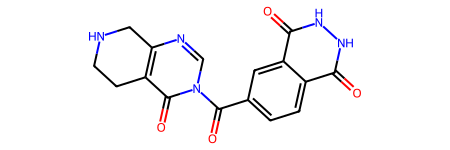

[6.208058890632141]


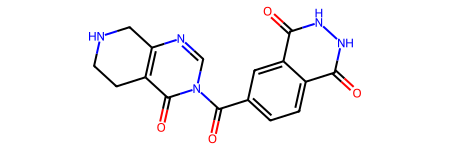

6.208058890632141


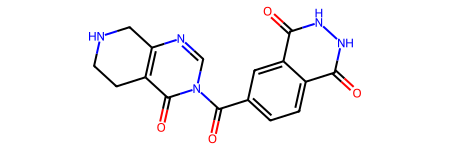

6.208058890632141


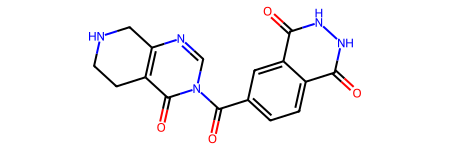

6.208058890632141


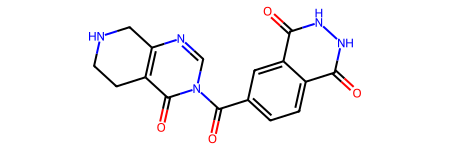

6.208058890632141


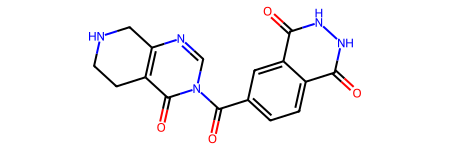

6.208058890632141


In [27]:
import numpy as np
from tqdm.notebook import tqdm

# best_mol = dg.molecule.Molecule(
#     'O=C(c1ccc2c(=O)[nH][nH]c(=O)c2c1)n1cnc2ccc(F)cc2c1=O',
#     reactants=['O=C(O)c1ccc2c(=O)[nH][nH]c(=O)c2c1',
#                'O=c1[nH]cnc2ccc(F)cc12']
# )
best_mol = dg.molecule.Molecule(
    'O=C(c1ccc2c(=O)[nH][nH]c(=O)c2c1)n1cnc2c(c1=O)CCNC2',
    reactants=['O=C(O)c1ccc2c(=O)[nH][nH]c(=O)c2c1',
               'Cl.O=c1[nH]cnc2c1CCNC2']
)

best_mol.reactants = best_mol.reactants[::-1]

# best_mol = deck[414]
best_score = docking_oracle([best_mol])

mols = [best_mol]
all_scores = [best_score]

for _ in tqdm(range(5)):
    
    display(best_mol)
    print(best_score)
    
    analogs = library_designer.design(
        best_mol,
        mode='analog',
        temperature=0.0,
        size=100
    )
    mols += analogs

    scores = docking_oracle(analogs)
    all_scores.extend(scores)
    
    best = np.nanargmax(scores).item()
    best_score = scores[best]
    best_mol = analogs[best]
    
display(best_mol)
print(best_score)

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


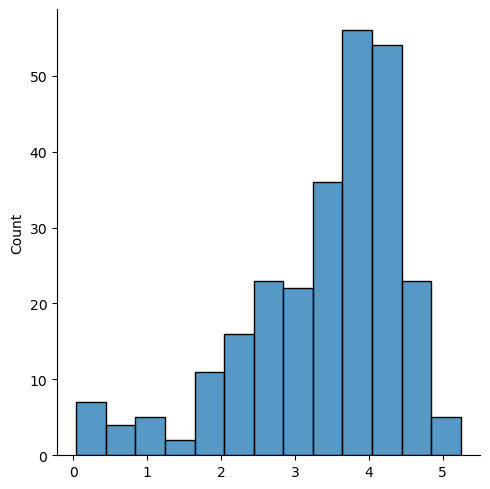

In [545]:
import seaborn as sns
pIC50s = np.array(docking_oracle(mols))
sns.displot(pIC50s[pIC50s > 0.0])